## 1. Setup & Installation

In [1]:
print(" Installing required packages...\n")

!pip install -q transformers datasets torch accelerate huggingface_hub tqdm scikit-learn matplotlib seaborn pandas

print(" Installation complete!\n")

📦 Installing required packages...

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 34.2 MB/s et

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import json
import random
from tqdm.auto import tqdm
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import os
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from huggingface_hub import HfApi, create_repo, login
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Setup
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*80)
print(" BAD Classifier Training (IMPROVED & BALANCED)")
print("="*80)
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print("="*80 + "\n")

🎯 BAD Classifier Training (IMPROVED & BALANCED)
Device: cuda
GPU: Tesla T4
GPU Memory: 14.74 GB



## 2. Improved Configuration

In [3]:
class TrainingConfig:
    """Improved configuration for balanced BAD classifier training"""
    
    # Model
    base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    max_length = 256
    
    # Datasets - SIMPLIFIED (BBQ only, NO MMLU)
    bbq_dataset_name = "bitlabsdb/BBQ_dataset"
    bbq_target_loc_dataset = "bitlabsdb/BBQ_Target_Loc_Dataset"
    num_bbq_samples = 58942  # Load all, then balance
    train_val_split = 0.8
    
    # Balanced sampling - KEY IMPROVEMENT


    # # Data - INCREASE sample size
    # target_samples_per_class = 20000  # 20k per class = 40k total (not 10k)
    use_balanced_sampling = True
    target_samples_per_class = 25000  # 10k per class = 20k total
    min_samples_per_class = 5000      # Minimum needed
    
    # Training - OPTIMIZED for balanced dataset
    # Following FairSteer Paper 
    batch_size = 128              # Larger batches for more stable gradients
    num_epochs = 150              # More epochs for convergence
    learning_rate = 1e-4          # Lower LR for simple linear classifier
    weight_decay = 1e-5           # Minimal regularization
    early_stopping_patience = 30  # More patience for slower LR
    gradient_clip_norm = 1.0      # Keep as is
    # Layer selection - Focused range
    candidate_layers_range = [12, 13, 14, 15]
    
    # Labels
    LABEL_BIASED = 0
    LABEL_UNBIASED = 1
    
    # Class weighting - DISABLED (not needed for balanced data)
    use_class_weights = False
    
    # HuggingFace
    hf_repo_name = "bitlabsdb/bad-classifier-tinyllama-fairsteer"
    hf_private = True
    
    # Local
    local_save_dir = "./bad_model_fairsteer"

config = TrainingConfig()

print("  FairSteer-Aligned Training Configuration:")
print("="*80)
print(f"Base Model:         {config.base_model_name}")
print(f"BBQ Dataset:        {config.bbq_dataset_name}")
print(f"Target_Loc Dataset: {config.bbq_target_loc_dataset}")
print(f"")
print(f" CRITICAL FIXES:")
print(f"    Context Condition:      Now using BBQ context_condition field")
print(f"    Proper Labeling:        FairSteer-aligned methodology")
print(f"    Increased Data:         {config.target_samples_per_class:,} per class")
print(f"    Expected total:         ~{config.target_samples_per_class*2:,} samples")
print(f"    Expanded Layers:        {len(config.candidate_layers_range)} layers tested")
print(f"")
print(f"Batch Size:         {config.batch_size} (larger for stability)")
print(f"Learning Rate:      {config.learning_rate} (lower for convergence)")
print(f"Epochs:             {config.num_epochs} (with early stopping)")
print(f"Early Stopping:     {config.early_stopping_patience} epochs")
print(f"Candidate Layers:   {config.candidate_layers_range}")
print("="*80 + "\n")

⚙️  FairSteer-Aligned Training Configuration:
Base Model:         TinyLlama/TinyLlama-1.1B-Chat-v1.0
BBQ Dataset:        bitlabsdb/BBQ_dataset
Target_Loc Dataset: bitlabsdb/BBQ_Target_Loc_Dataset

🔑 CRITICAL FIXES:
   ✅ Context Condition:      Now using BBQ context_condition field
   ✅ Proper Labeling:        FairSteer-aligned methodology
   ✅ Increased Data:         25,000 per class
   ✅ Expected total:         ~50,000 samples
   ✅ Expanded Layers:        4 layers tested

Batch Size:         128 (larger for stability)
Learning Rate:      0.0001 (lower for convergence)
Epochs:             150 (with early stopping)
Early Stopping:     30 epochs
Candidate Layers:   [12, 13, 14, 15]



## 3. Model Definition

In [4]:
class BADClassifier(nn.Module):
    """
    Biased Activation Detection (BAD) Classifier - FairSteer Aligned
    
    Simple linear classifier as specified in FairSteer framework.
    Uses sigmoid activation for binary classification (biased vs unbiased).
    
    Architecture: Linear layer → Sigmoid (single output)
    Output: Probability of being UNBIASED (p(y=1))
    Decision: p(y=1) < 0.5 → BIASED (trigger steering)
              p(y=1) >= 0.5 → UNBIASED (no steering needed)
    """
    
    def __init__(self, input_dim: int):
        super().__init__()
        # Single linear layer: input_dim → 1 (binary classification)
        self.linear = nn.Linear(input_dim, 1)
        self.input_dim = input_dim
        
        # Xavier initialization for stable training
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)
    
    def forward(self, x):
        """
        Forward pass with sigmoid activation
        Returns: logits (before sigmoid)
        """
        return self.linear(x)
    
    def predict_proba(self, x):
        """
        Get probability of being UNBIASED
        Returns: p(y=1) where y=1 means UNBIASED
        """
        logits = self.forward(x)
        # Sigmoid gives probability between 0 and 1
        probs = torch.sigmoid(logits).squeeze(-1)
        return probs
    
    def detect_bias(self, x, threshold: float = 0.5):
        """
        Detect biased activations using FairSteer threshold
        
        Args:
            x: Input activations
            threshold: Decision threshold (default 0.5)
        
        Returns:
            is_biased: Boolean tensor indicating biased samples
            unbiased_prob: Probability of being unbiased p(y=1)
        """
        unbiased_prob = self.predict_proba(x)
        # FairSteer condition: p(y=1) < 0.5 means BIASED
        is_biased = unbiased_prob < threshold
        return is_biased, unbiased_prob

print(" BAD Classifier defined (FairSteer-aligned: Linear + Sigmoid)\n")

✅ BAD Classifier defined (FairSteer-aligned: Linear + Sigmoid)



## 4. Data Loading

In [5]:
def load_and_merge_bbq_with_targetloc(config: TrainingConfig) -> pd.DataFrame:
    """Load BBQ dataset and merge with target_loc"""
    
    print("="*80)
    print(" Loading BBQ Dataset with Target_Loc")
    print("="*80 + "\n")
    
    # Load BBQ
    print("Loading BBQ dataset...")
    try:
        bbq_dataset = load_dataset(config.bbq_dataset_name)
        print(f" Loaded BBQ: {config.bbq_dataset_name}")
    except:
        bbq_dataset = load_dataset("nyu-mll/BBQ")
        print(f" Loaded BBQ: nyu-mll/BBQ")
    
    # Load Target_Loc
    print("\nLoading Target_Loc dataset...")
    from huggingface_hub import hf_hub_download
    
    csv_path = hf_hub_download(
        repo_id=config.bbq_target_loc_dataset,
        filename="Untitled spreadsheet - additional_metadata.csv",
        repo_type="dataset"
    )
    
    targetloc_df = pd.read_csv(csv_path, keep_default_na=False)
    targetloc_df['target_loc'] = pd.to_numeric(targetloc_df['target_loc'], errors='coerce')
    
    # Deduplicate
    if targetloc_df['example_id'].duplicated().any():
        targetloc_df = targetloc_df.drop_duplicates(subset=['example_id'], keep='first')
    
    print(f" Loaded Target_Loc")
    
    # Merge
    bbq_df = pd.DataFrame(bbq_dataset['train'])
    merged_df = pd.merge(
        bbq_df,
        targetloc_df[['example_id', 'target_loc']],
        on='example_id',
        how='inner'
    )
    
    # Clean
    merged_df = merged_df[merged_df['target_loc'].notnull()]
    merged_df = merged_df[merged_df['target_loc'].isin([0, 1, 2])]
    
    if len(merged_df) > config.num_bbq_samples:
        merged_df = merged_df.sample(n=config.num_bbq_samples, random_state=SEED)
    
    print(f"\n Final BBQ dataset: {len(merged_df):,} rows")
    print("="*80 + "\n")
    
    return merged_df

# Load BBQ
bbq_merged_df = load_and_merge_bbq_with_targetloc(config)
print(f"Sample: {len(bbq_merged_df)} BBQ examples loaded\n")

📚 Loading BBQ Dataset with Target_Loc

Loading BBQ dataset...


README.md: 0.00B [00:00, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


Age.jsonl: 0.00B [00:00, ?B/s]

Disability_status.jsonl: 0.00B [00:00, ?B/s]

Gender_identity.jsonl: 0.00B [00:00, ?B/s]

Nationality.jsonl: 0.00B [00:00, ?B/s]

Physical_appearance.jsonl: 0.00B [00:00, ?B/s]

Race_ethnicity.jsonl: 0.00B [00:00, ?B/s]

Race_x_SES.jsonl:   0%|          | 0.00/11.2M [00:00<?, ?B/s]

Race_x_gender.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Religion.jsonl: 0.00B [00:00, ?B/s]

SES.jsonl: 0.00B [00:00, ?B/s]

Sexual_orientation.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/58492 [00:00<?, ? examples/s]

✅ Loaded BBQ: bitlabsdb/BBQ_dataset

Loading Target_Loc dataset...


(…)preadsheet%20-%20additional_metadata.csv: 0.00B [00:00, ?B/s]

✅ Loaded Target_Loc

✅ Final BBQ dataset: 58,492 rows

Sample: 58492 BBQ examples loaded



## 5. Load Base Model

In [6]:
print("="*80)
print(" Loading Base Model")
print("="*80 + "\n")

tokenizer = AutoTokenizer.from_pretrained(config.base_model_name)
base_model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map='auto'
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base_model.eval()

print(f" Loaded {config.base_model_name}")
print(f"   Hidden size: {base_model.config.hidden_size}")
print("="*80 + "\n")

🤖 Loading Base Model



tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

2025-11-16 01:32:27.814149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763256747.991156      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763256748.042888      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ Loaded TinyLlama/TinyLlama-1.1B-Chat-v1.0
   Hidden size: 2048



## 6. Extract BBQ Activations

In [7]:
def extract_bbq_activations(
    model,
    tokenizer,
    merged_df: pd.DataFrame,
    config: TrainingConfig,
    layer_idx: int
) -> Tuple[List[np.ndarray], List[int]]:
    """
    Extract activations and generate labels from BBQ - FAIRSTEER-ALIGNED
    
    Critical Fix: Now uses context_condition to properly label examples
    - Ambiguous context + Stereotype → BIASED
    - Ambiguous context + No Stereotype → UNBIASED
    - Disambiguated context + Correct → UNBIASED
    - Disambiguated context + Incorrect → BIASED
    """
    
    model.eval()
    activations = []
    labels = []
    stats = {
        'biased': 0, 
        'unbiased': 0, 
        'failed': 0,
        'ambig_stereo': 0,
        'ambig_nostereo': 0,
        'disambig_correct': 0,
        'disambig_incorrect': 0
    }
    
    for idx, row in tqdm(merged_df.iterrows(), total=len(merged_df), desc=f"BBQ Layer {layer_idx}"):
        try:
            context = row.get('context', '')
            question = row.get('question', '')
            ans0 = row.get('ans0', '')
            ans1 = row.get('ans1', '')
            ans2 = row.get('ans2', '')
            target_loc = int(row.get('target_loc', -1))
            
            
            context_condition = row.get('context_condition', '')
            answer_info = row.get('answer_info', '')
            
            # Skip if missing critical fields
            if target_loc == -1 or context_condition == '':
                stats['failed'] += 1
                continue
            
            prompt = f"{context} {question}\\nA. {ans0}\\nB. {ans1}\\nC. {ans2}\\nAnswer:"
            
            inputs = tokenizer(
                prompt,
                return_tensors="pt",
                max_length=config.max_length,
                truncation=True,
                padding=True
            ).to(device)
            
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True, return_dict=True)
            
            # Extract last token hidden state from specified layer
            hidden_states = outputs.hidden_states[layer_idx]
            last_token_hidden = hidden_states[:, -1, :].cpu().numpy()[0]
            
            # Get model's prediction probabilities
            logits = outputs.logits[:, -1, :]
            token_a = tokenizer.encode('A', add_special_tokens=False)[0]
            token_b = tokenizer.encode('B', add_special_tokens=False)[0]
            token_c = tokenizer.encode('C', add_special_tokens=False)[0]
            
            probs = torch.softmax(logits, dim=-1)
            prob_a = probs[0, token_a].item()
            prob_b = probs[0, token_b].item()
            prob_c = probs[0, token_c].item()
            
            predicted_idx = np.argmax([prob_a, prob_b, prob_c])
            
       
            if context_condition == 'ambig':
                # AMBIGUOUS CONTEXT: Not enough information to answer
                # Correct answer should be "Unknown" (typically index 2)
                # Answering with stereotype (target_loc) = BIASED
                if predicted_idx == target_loc:
                    label = config.LABEL_BIASED  # Gave stereotypical answer
                    stats['ambig_stereo'] += 1
                else:
                    label = config.LABEL_UNBIASED  # Avoided stereotype
                    stats['ambig_nostereo'] += 1
                    
            elif context_condition == 'disambig':
                # DISAMBIGUATED CONTEXT: Enough information provided
                # There IS a correct answer (not "Unknown")
                # Model should give a definitive answer
                
                # In disambig contexts, "Unknown" (index 2) is WRONG
                if predicted_idx == 2:
                    label = config.LABEL_BIASED  # Incorrectly said "Unknown"
                    stats['disambig_incorrect'] += 1
                else:
                    label = config.LABEL_UNBIASED  # Gave definitive answer
                    stats['disambig_correct'] += 1
            else:
                # Unknown context condition - skip
                stats['failed'] += 1
                continue
            
            # Store activation and label
            activations.append(last_token_hidden)
            labels.append(label)
            
            if label == config.LABEL_BIASED:
                stats['biased'] += 1
            else:
                stats['unbiased'] += 1
                
        except Exception as e:
            stats['failed'] += 1
            continue
    
    # Print detailed statistics
    print(f"\\n BBQ Extraction Stats (FairSteer-Aligned):")
    print(f"   BIASED:   {stats['biased']:,} ({stats['biased']/(stats['biased']+stats['unbiased'])*100:.1f}%)")
    print(f"     - Ambig + Stereotype:     {stats['ambig_stereo']:,}")
    print(f"     - Disambig + Incorrect:   {stats['disambig_incorrect']:,}")
    print(f"   UNBIASED: {stats['unbiased']:,} ({stats['unbiased']/(stats['biased']+stats['unbiased'])*100:.1f}%)")
    print(f"     - Ambig + No Stereotype:  {stats['ambig_nostereo']:,}")
    print(f"     - Disambig + Correct:     {stats['disambig_correct']:,}")
    print(f"   Failed:   {stats['failed']:,}")
    print(f"   Total:    {stats['biased']+stats['unbiased']:,}")
    print(f"")
    
    return activations, labels

print("✅ FairSteer-aligned extraction function defined\\n")

✅ FairSteer-aligned extraction function defined\n


## 7. Balance Dataset (KEY IMPROVEMENT)

In [8]:
def balance_dataset(
    activations: List[np.ndarray],
    labels: List[int],
    config: TrainingConfig
) -> Tuple[List[np.ndarray], List[int]]:
    """
    Balance dataset to have equal samples per class
    This is the KEY improvement that fixes class imbalance
    """
    
    print("\n" + "="*80)
    print("  Balancing Dataset (KEY IMPROVEMENT)")
    print("="*80 + "\n")
    
    # Separate by class
    biased_indices = [i for i, l in enumerate(labels) if l == config.LABEL_BIASED]
    unbiased_indices = [i for i, l in enumerate(labels) if l == config.LABEL_UNBIASED]
    
    print(f"Original distribution:")
    print(f"   BIASED:   {len(biased_indices):,} ({len(biased_indices)/len(labels)*100:.1f}%)")
    print(f"   UNBIASED: {len(unbiased_indices):,} ({len(unbiased_indices)/len(labels)*100:.1f}%)")
    print(f"   Total:    {len(labels):,}")
    print(f"   Imbalance ratio: {max(len(biased_indices), len(unbiased_indices)) / min(len(biased_indices), len(unbiased_indices)):.1f}:1")
    
    # Check minimum
    min_class_size = min(len(biased_indices), len(unbiased_indices))
    if min_class_size < config.min_samples_per_class:
        print(f"\n  WARNING: Minority class has only {min_class_size:,} samples")
        print(f"   Minimum needed: {config.min_samples_per_class:,}")
        print(f"   Training may not be optimal!\n")
    
    # Determine target per class
    target_per_class = min_class_size
    if config.target_samples_per_class:
        target_per_class = min(target_per_class, config.target_samples_per_class)
    
    print(f"\n Balancing to {target_per_class:,} samples per class...")
    
    # Random sample
    biased_sample = random.sample(biased_indices, target_per_class)
    unbiased_sample = random.sample(unbiased_indices, target_per_class)
    
    # Combine and shuffle
    balanced_indices = biased_sample + unbiased_sample
    random.shuffle(balanced_indices)
    
    # Create balanced dataset
    balanced_activations = [activations[i] for i in balanced_indices]
    balanced_labels = [labels[i] for i in balanced_indices]
    
    print(f"\n Balanced dataset created:")
    print(f"   BIASED:   {target_per_class:,} (50.0%)")
    print(f"   UNBIASED: {target_per_class:,} (50.0%)")
    print(f"   Total:    {len(balanced_labels):,}")
    print(f"\n Size reduction: {len(labels):,} → {len(balanced_labels):,} ({len(balanced_labels)/len(labels)*100:.1f}%)")
    print(f"  Imbalance fixed: 50-50 split!")
    print(f" New baseline: 50% (random guessing)")
    print("="*80 + "\n")
    
    return balanced_activations, balanced_labels

## 8. Extract and Balance for All Layers

In [9]:
print("="*80)
print(" Extracting & Balancing Data for All Layers")
print("="*80 + "\n")

all_layer_data = {}

for layer_idx in config.candidate_layers_range:
    print(f"\n{'='*80}")
    print(f"Layer {layer_idx}")
    print(f"{'='*80}\n")
    
    # Extract BBQ activations
    bbq_activations, bbq_labels = extract_bbq_activations(
        base_model,
        tokenizer,
        bbq_merged_df,
        config,
        layer_idx
    )
    
    # Balance dataset (NO MMLU!)
    if config.use_balanced_sampling:
        balanced_activations, balanced_labels = balance_dataset(
            bbq_activations,
            bbq_labels,
            config
        )
    else:
        balanced_activations = bbq_activations
        balanced_labels = bbq_labels
    
    all_layer_data[layer_idx] = {
        'activations': balanced_activations,
        'labels': balanced_labels
    }
    
    print(f" Layer {layer_idx} ready: {len(balanced_activations):,} balanced samples")

print(f"\n{'='*80}")
print(" Data extraction and balancing complete!")
print(f"{'='*80}\n")

🔬 Extracting & Balancing Data for All Layers


Layer 12



BBQ Layer 12:   0%|          | 0/58492 [00:00<?, ?it/s]

\n📊 BBQ Extraction Stats (FairSteer-Aligned):
   BIASED:   12,138 (20.8%)
     - Ambig + Stereotype:     9,883
     - Disambig + Incorrect:   2,255
   UNBIASED: 46,354 (79.2%)
     - Ambig + No Stereotype:  19,363
     - Disambig + Correct:     26,991
   Failed:   0
   Total:    58,492


⚖️  Balancing Dataset (KEY IMPROVEMENT)

Original distribution:
   BIASED:   12,138 (20.8%)
   UNBIASED: 46,354 (79.2%)
   Total:    58,492
   Imbalance ratio: 3.8:1

🎯 Balancing to 12,138 samples per class...

✅ Balanced dataset created:
   BIASED:   12,138 (50.0%)
   UNBIASED: 12,138 (50.0%)
   Total:    24,276

📉 Size reduction: 58,492 → 24,276 (41.5%)
⚖️  Imbalance fixed: 50-50 split!
🎯 New baseline: 50% (random guessing)

✅ Layer 12 ready: 24,276 balanced samples

Layer 13



BBQ Layer 13:   0%|          | 0/58492 [00:00<?, ?it/s]

\n📊 BBQ Extraction Stats (FairSteer-Aligned):
   BIASED:   12,138 (20.8%)
     - Ambig + Stereotype:     9,883
     - Disambig + Incorrect:   2,255
   UNBIASED: 46,354 (79.2%)
     - Ambig + No Stereotype:  19,363
     - Disambig + Correct:     26,991
   Failed:   0
   Total:    58,492


⚖️  Balancing Dataset (KEY IMPROVEMENT)

Original distribution:
   BIASED:   12,138 (20.8%)
   UNBIASED: 46,354 (79.2%)
   Total:    58,492
   Imbalance ratio: 3.8:1

🎯 Balancing to 12,138 samples per class...

✅ Balanced dataset created:
   BIASED:   12,138 (50.0%)
   UNBIASED: 12,138 (50.0%)
   Total:    24,276

📉 Size reduction: 58,492 → 24,276 (41.5%)
⚖️  Imbalance fixed: 50-50 split!
🎯 New baseline: 50% (random guessing)

✅ Layer 13 ready: 24,276 balanced samples

Layer 14



BBQ Layer 14:   0%|          | 0/58492 [00:00<?, ?it/s]

\n📊 BBQ Extraction Stats (FairSteer-Aligned):
   BIASED:   12,138 (20.8%)
     - Ambig + Stereotype:     9,883
     - Disambig + Incorrect:   2,255
   UNBIASED: 46,354 (79.2%)
     - Ambig + No Stereotype:  19,363
     - Disambig + Correct:     26,991
   Failed:   0
   Total:    58,492


⚖️  Balancing Dataset (KEY IMPROVEMENT)

Original distribution:
   BIASED:   12,138 (20.8%)
   UNBIASED: 46,354 (79.2%)
   Total:    58,492
   Imbalance ratio: 3.8:1

🎯 Balancing to 12,138 samples per class...

✅ Balanced dataset created:
   BIASED:   12,138 (50.0%)
   UNBIASED: 12,138 (50.0%)
   Total:    24,276

📉 Size reduction: 58,492 → 24,276 (41.5%)
⚖️  Imbalance fixed: 50-50 split!
🎯 New baseline: 50% (random guessing)

✅ Layer 14 ready: 24,276 balanced samples

Layer 15



BBQ Layer 15:   0%|          | 0/58492 [00:00<?, ?it/s]

\n📊 BBQ Extraction Stats (FairSteer-Aligned):
   BIASED:   12,138 (20.8%)
     - Ambig + Stereotype:     9,883
     - Disambig + Incorrect:   2,255
   UNBIASED: 46,354 (79.2%)
     - Ambig + No Stereotype:  19,363
     - Disambig + Correct:     26,991
   Failed:   0
   Total:    58,492


⚖️  Balancing Dataset (KEY IMPROVEMENT)

Original distribution:
   BIASED:   12,138 (20.8%)
   UNBIASED: 46,354 (79.2%)
   Total:    58,492
   Imbalance ratio: 3.8:1

🎯 Balancing to 12,138 samples per class...

✅ Balanced dataset created:
   BIASED:   12,138 (50.0%)
   UNBIASED: 12,138 (50.0%)
   Total:    24,276

📉 Size reduction: 58,492 → 24,276 (41.5%)
⚖️  Imbalance fixed: 50-50 split!
🎯 New baseline: 50% (random guessing)

✅ Layer 15 ready: 24,276 balanced samples

✅ Data extraction and balancing complete!



## 9. Training Function

In [10]:
def train_bad_classifier(
    activations: List[np.ndarray],
    labels: List[int],
    config: TrainingConfig,
    layer_idx: int
) -> Tuple[BADClassifier, float, Dict]:
    """Train BAD classifier on balanced data with Binary Cross-Entropy loss"""
    
    print(f"\n{'='*80}")
    print(f"Training BAD Classifier - Layer {layer_idx}")
    print(f"{'='*80}\n")
    
    # Convert to tensors
    X = torch.tensor(np.array(activations), dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32)  # Float for BCEWithLogitsLoss
    
    print(f"Dataset: {len(X):,} samples")
    print(f"Input dim: {X.shape[1]}")
    print(f"Label distribution: BIASED={int((y==0).sum())}, UNBIASED={int((y==1).sum())}")
    
    # Split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=1-config.train_val_split, random_state=SEED, stratify=y
    )
    
    print(f"Train: {len(X_train):,} | Val: {len(X_val):,}\n")
    
    # Create dataloaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.batch_size, 
        shuffle=True,
        drop_last=False
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False
    )
    
    # Initialize model
    model = BADClassifier(input_dim=X.shape[1]).to(device)
    
    # Binary Cross-Entropy Loss (more appropriate for sigmoid output)
    criterion = nn.BCEWithLogitsLoss()  # Includes sigmoid + BCE
    
    # Optimizer
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, verbose=True
    )
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr': []
    }
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    print(" Starting training...\n")
    
    for epoch in range(config.num_epochs):
        # TRAINING
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.num_epochs}")
        for batch_X, batch_y in pbar:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass (returns logits)
            logits = model(batch_X).squeeze(-1)
            loss = criterion(logits, batch_y)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            if config.gradient_clip_norm > 0:
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), 
                    config.gradient_clip_norm
                )
            
            optimizer.step()
            
            # Metrics
            train_loss += loss.item() * len(batch_X)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()  # Threshold at 0.5
            train_correct += (preds == batch_y.long()).sum().item()
            train_total += len(batch_X)
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{train_correct/train_total:.4f}"
            })
        
        train_loss /= train_total
        train_acc = train_correct / train_total
        
        # VALIDATION
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                logits = model(batch_X).squeeze(-1)
                loss = criterion(logits, batch_y)
                
                val_loss += loss.item() * len(batch_X)
                probs = torch.sigmoid(logits)
                preds = (probs >= 0.5).long()
                val_correct += (preds == batch_y.long()).sum().item()
                val_total += len(batch_X)
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{config.num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Early stopping & best model tracking
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"   New best! Val Acc: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            print(f"  Patience: {patience_counter}/{config.early_stopping_patience}")
        
        if patience_counter >= config.early_stopping_patience:
            print(f"\n⏹  Early stopping triggered at epoch {epoch+1}")
            break
        
        print()
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    print(f"\n{'='*80}")
    print(f" Training Complete - Layer {layer_idx}")
    print(f"   Best Val Accuracy: {best_val_acc:.4f}")
    print(f"{'='*80}\n")
    
    return model, best_val_acc, history

## 10. Train All Layers & Select Best

In [11]:
print("="*80)
print(" Training BAD Classifiers for All Layers")
print("="*80 + "\n")

layer_results = {}
trained_classifiers = {}
training_histories = {}

best_layer = None
best_val_acc = 0.0
best_classifier = None
best_history = None

for layer_idx in config.candidate_layers_range:
    print(f"\n{'='*80}")
    print(f"LAYER {layer_idx}")
    print(f"{'='*80}")
    
    classifier, val_acc, history = train_bad_classifier(
        all_layer_data[layer_idx]['activations'],
        all_layer_data[layer_idx]['labels'],
        config,
        layer_idx
    )
    
    layer_results[layer_idx] = val_acc
    trained_classifiers[layer_idx] = classifier
    training_histories[layer_idx] = history
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_layer = layer_idx
        best_classifier = classifier
        best_history = history

print(f"\n{'='*80}")
print(" Layer Selection Results")
print(f"{'='*80}\n")

print(f"{'Layer':<8} {'Val Accuracy':<15} {'Status'}")
print("-" * 40)
for layer in sorted(layer_results.keys()):
    acc = layer_results[layer]
    marker = " ← BEST ✓" if layer == best_layer else ""
    print(f"{layer:<8} {acc:<15.4f} {marker}")

print(f"\n{'='*80}")
print(f" Selected Layer {best_layer} with accuracy {best_val_acc:.4f}")
print(f"{'='*80}\n")

# Success check
if best_val_acc >= 0.75:
    print(" SUCCESS! Accuracy ≥ 75% - Model is well-trained!")
elif best_val_acc >= 0.70:
    print(" GOOD! Accuracy ≥ 70% - Model is usable.")
elif best_val_acc >= 0.60:
    print("  MODERATE. Accuracy 60-70% - May need improvement.")
else:
    print(" POOR. Accuracy < 60% - Not ready for production.")

trained_classifier = best_classifier
training_history = best_history

🎯 Training BAD Classifiers for All Layers


LAYER 12

Training BAD Classifier - Layer 12

Dataset: 24,276 samples
Input dim: 2048
Label distribution: BIASED=12138, UNBIASED=12138
Train: 19,420 | Val: 4,856

🚀 Starting training...



Epoch 1/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 1/150:
  Train Loss: 0.6882 | Train Acc: 0.5727
  Val Loss:   0.6837 | Val Acc:   0.5935
  ✅ New best! Val Acc: 0.5935



Epoch 2/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 2/150:
  Train Loss: 0.6790 | Train Acc: 0.6342
  Val Loss:   0.6756 | Val Acc:   0.6339
  ✅ New best! Val Acc: 0.6339



Epoch 3/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 3/150:
  Train Loss: 0.6711 | Train Acc: 0.6436
  Val Loss:   0.6687 | Val Acc:   0.6369
  ✅ New best! Val Acc: 0.6369



Epoch 4/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 4/150:
  Train Loss: 0.6643 | Train Acc: 0.6432
  Val Loss:   0.6630 | Val Acc:   0.6501
  ✅ New best! Val Acc: 0.6501



Epoch 5/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 5/150:
  Train Loss: 0.6584 | Train Acc: 0.6519
  Val Loss:   0.6578 | Val Acc:   0.6470
  Patience: 1/30



Epoch 6/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 6/150:
  Train Loss: 0.6534 | Train Acc: 0.6536
  Val Loss:   0.6535 | Val Acc:   0.6433
  Patience: 2/30



Epoch 7/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 7/150:
  Train Loss: 0.6489 | Train Acc: 0.6554
  Val Loss:   0.6497 | Val Acc:   0.6507
  ✅ New best! Val Acc: 0.6507



Epoch 8/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 8/150:
  Train Loss: 0.6450 | Train Acc: 0.6558
  Val Loss:   0.6462 | Val Acc:   0.6497
  Patience: 1/30



Epoch 9/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 9/150:
  Train Loss: 0.6416 | Train Acc: 0.6590
  Val Loss:   0.6433 | Val Acc:   0.6516
  ✅ New best! Val Acc: 0.6516



Epoch 10/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 10/150:
  Train Loss: 0.6387 | Train Acc: 0.6584
  Val Loss:   0.6411 | Val Acc:   0.6573
  ✅ New best! Val Acc: 0.6573



Epoch 11/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 11/150:
  Train Loss: 0.6360 | Train Acc: 0.6614
  Val Loss:   0.6384 | Val Acc:   0.6507
  Patience: 1/30



Epoch 12/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 12/150:
  Train Loss: 0.6335 | Train Acc: 0.6620
  Val Loss:   0.6364 | Val Acc:   0.6534
  Patience: 2/30



Epoch 13/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 13/150:
  Train Loss: 0.6314 | Train Acc: 0.6628
  Val Loss:   0.6345 | Val Acc:   0.6526
  Patience: 3/30



Epoch 14/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 14/150:
  Train Loss: 0.6293 | Train Acc: 0.6624
  Val Loss:   0.6331 | Val Acc:   0.6555
  Patience: 4/30



Epoch 15/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 15/150:
  Train Loss: 0.6275 | Train Acc: 0.6654
  Val Loss:   0.6313 | Val Acc:   0.6505
  Patience: 5/30



Epoch 16/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 16/150:
  Train Loss: 0.6258 | Train Acc: 0.6658
  Val Loss:   0.6299 | Val Acc:   0.6547
  Patience: 6/30



Epoch 17/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 17/150:
  Train Loss: 0.6246 | Train Acc: 0.6686
  Val Loss:   0.6293 | Val Acc:   0.6532
  Patience: 7/30



Epoch 18/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 18/150:
  Train Loss: 0.6239 | Train Acc: 0.6678
  Val Loss:   0.6286 | Val Acc:   0.6551
  Patience: 8/30



Epoch 19/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 19/150:
  Train Loss: 0.6231 | Train Acc: 0.6695
  Val Loss:   0.6280 | Val Acc:   0.6561
  Patience: 9/30



Epoch 20/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 20/150:
  Train Loss: 0.6224 | Train Acc: 0.6670
  Val Loss:   0.6276 | Val Acc:   0.6590
  ✅ New best! Val Acc: 0.6590



Epoch 21/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 21/150:
  Train Loss: 0.6218 | Train Acc: 0.6695
  Val Loss:   0.6268 | Val Acc:   0.6547
  Patience: 1/30



Epoch 22/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 22/150:
  Train Loss: 0.6211 | Train Acc: 0.6684
  Val Loss:   0.6264 | Val Acc:   0.6594
  ✅ New best! Val Acc: 0.6594



Epoch 23/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 23/150:
  Train Loss: 0.6206 | Train Acc: 0.6707
  Val Loss:   0.6258 | Val Acc:   0.6542
  Patience: 1/30



Epoch 24/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 24/150:
  Train Loss: 0.6199 | Train Acc: 0.6689
  Val Loss:   0.6253 | Val Acc:   0.6573
  Patience: 2/30



Epoch 25/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 25/150:
  Train Loss: 0.6193 | Train Acc: 0.6715
  Val Loss:   0.6248 | Val Acc:   0.6569
  Patience: 3/30



Epoch 26/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 26/150:
  Train Loss: 0.6188 | Train Acc: 0.6690
  Val Loss:   0.6244 | Val Acc:   0.6538
  Patience: 4/30



Epoch 27/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 27/150:
  Train Loss: 0.6181 | Train Acc: 0.6687
  Val Loss:   0.6239 | Val Acc:   0.6614
  ✅ New best! Val Acc: 0.6614



Epoch 28/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 28/150:
  Train Loss: 0.6177 | Train Acc: 0.6706
  Val Loss:   0.6236 | Val Acc:   0.6621
  ✅ New best! Val Acc: 0.6621



Epoch 29/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 29/150:
  Train Loss: 0.6172 | Train Acc: 0.6716
  Val Loss:   0.6230 | Val Acc:   0.6588
  Patience: 1/30



Epoch 30/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 30/150:
  Train Loss: 0.6167 | Train Acc: 0.6714
  Val Loss:   0.6226 | Val Acc:   0.6600
  Patience: 2/30



Epoch 31/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 31/150:
  Train Loss: 0.6161 | Train Acc: 0.6727
  Val Loss:   0.6222 | Val Acc:   0.6567
  Patience: 3/30



Epoch 32/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 32/150:
  Train Loss: 0.6157 | Train Acc: 0.6721
  Val Loss:   0.6218 | Val Acc:   0.6557
  Patience: 4/30



Epoch 33/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 33/150:
  Train Loss: 0.6153 | Train Acc: 0.6726
  Val Loss:   0.6213 | Val Acc:   0.6586
  Patience: 5/30



Epoch 34/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 34/150:
  Train Loss: 0.6148 | Train Acc: 0.6729
  Val Loss:   0.6210 | Val Acc:   0.6569
  Patience: 6/30



Epoch 35/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 35/150:
  Train Loss: 0.6144 | Train Acc: 0.6727
  Val Loss:   0.6208 | Val Acc:   0.6561
  Patience: 7/30



Epoch 36/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 36/150:
  Train Loss: 0.6141 | Train Acc: 0.6731
  Val Loss:   0.6206 | Val Acc:   0.6561
  Patience: 8/30



Epoch 37/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 37/150:
  Train Loss: 0.6139 | Train Acc: 0.6731
  Val Loss:   0.6204 | Val Acc:   0.6563
  Patience: 9/30



Epoch 38/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 38/150:
  Train Loss: 0.6137 | Train Acc: 0.6729
  Val Loss:   0.6202 | Val Acc:   0.6582
  Patience: 10/30



Epoch 39/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 39/150:
  Train Loss: 0.6135 | Train Acc: 0.6728
  Val Loss:   0.6201 | Val Acc:   0.6621
  Patience: 11/30



Epoch 40/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 40/150:
  Train Loss: 0.6133 | Train Acc: 0.6735
  Val Loss:   0.6199 | Val Acc:   0.6619
  Patience: 12/30



Epoch 41/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 41/150:
  Train Loss: 0.6131 | Train Acc: 0.6743
  Val Loss:   0.6198 | Val Acc:   0.6604
  Patience: 13/30



Epoch 42/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 42/150:
  Train Loss: 0.6130 | Train Acc: 0.6738
  Val Loss:   0.6197 | Val Acc:   0.6604
  Patience: 14/30



Epoch 43/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 43/150:
  Train Loss: 0.6129 | Train Acc: 0.6740
  Val Loss:   0.6196 | Val Acc:   0.6594
  Patience: 15/30



Epoch 44/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 44/150:
  Train Loss: 0.6128 | Train Acc: 0.6738
  Val Loss:   0.6195 | Val Acc:   0.6600
  Patience: 16/30



Epoch 45/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 45/150:
  Train Loss: 0.6127 | Train Acc: 0.6740
  Val Loss:   0.6194 | Val Acc:   0.6598
  Patience: 17/30



Epoch 46/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 46/150:
  Train Loss: 0.6126 | Train Acc: 0.6742
  Val Loss:   0.6194 | Val Acc:   0.6600
  Patience: 18/30



Epoch 47/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 47/150:
  Train Loss: 0.6125 | Train Acc: 0.6742
  Val Loss:   0.6193 | Val Acc:   0.6602
  Patience: 19/30



Epoch 48/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 48/150:
  Train Loss: 0.6124 | Train Acc: 0.6741
  Val Loss:   0.6193 | Val Acc:   0.6606
  Patience: 20/30



Epoch 49/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 49/150:
  Train Loss: 0.6124 | Train Acc: 0.6740
  Val Loss:   0.6192 | Val Acc:   0.6602
  Patience: 21/30



Epoch 50/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 50/150:
  Train Loss: 0.6123 | Train Acc: 0.6740
  Val Loss:   0.6192 | Val Acc:   0.6604
  Patience: 22/30



Epoch 51/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 51/150:
  Train Loss: 0.6123 | Train Acc: 0.6743
  Val Loss:   0.6191 | Val Acc:   0.6602
  Patience: 23/30



Epoch 52/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 52/150:
  Train Loss: 0.6122 | Train Acc: 0.6742
  Val Loss:   0.6191 | Val Acc:   0.6602
  Patience: 24/30



Epoch 53/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 53/150:
  Train Loss: 0.6122 | Train Acc: 0.6742
  Val Loss:   0.6191 | Val Acc:   0.6602
  Patience: 25/30



Epoch 54/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 54/150:
  Train Loss: 0.6122 | Train Acc: 0.6740
  Val Loss:   0.6191 | Val Acc:   0.6602
  Patience: 26/30



Epoch 55/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 55/150:
  Train Loss: 0.6121 | Train Acc: 0.6744
  Val Loss:   0.6190 | Val Acc:   0.6600
  Patience: 27/30



Epoch 56/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 56/150:
  Train Loss: 0.6121 | Train Acc: 0.6739
  Val Loss:   0.6190 | Val Acc:   0.6600
  Patience: 28/30



Epoch 57/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 57/150:
  Train Loss: 0.6121 | Train Acc: 0.6742
  Val Loss:   0.6190 | Val Acc:   0.6602
  Patience: 29/30



Epoch 58/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 58/150:
  Train Loss: 0.6121 | Train Acc: 0.6743
  Val Loss:   0.6190 | Val Acc:   0.6600
  Patience: 30/30

⏹  Early stopping triggered at epoch 58

✅ Training Complete - Layer 12
   Best Val Accuracy: 0.6621


LAYER 13

Training BAD Classifier - Layer 13

Dataset: 24,276 samples
Input dim: 2048
Label distribution: BIASED=12138, UNBIASED=12138
Train: 19,420 | Val: 4,856

🚀 Starting training...



Epoch 1/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 1/150:
  Train Loss: 0.6880 | Train Acc: 0.5770
  Val Loss:   0.6815 | Val Acc:   0.6442
  ✅ New best! Val Acc: 0.6442



Epoch 2/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 2/150:
  Train Loss: 0.6775 | Train Acc: 0.6386
  Val Loss:   0.6711 | Val Acc:   0.6697
  ✅ New best! Val Acc: 0.6697



Epoch 3/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 3/150:
  Train Loss: 0.6690 | Train Acc: 0.6524
  Val Loss:   0.6624 | Val Acc:   0.6577
  Patience: 1/30



Epoch 4/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 4/150:
  Train Loss: 0.6619 | Train Acc: 0.6524
  Val Loss:   0.6550 | Val Acc:   0.6691
  Patience: 2/30



Epoch 5/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 5/150:
  Train Loss: 0.6559 | Train Acc: 0.6526
  Val Loss:   0.6488 | Val Acc:   0.6650
  Patience: 3/30



Epoch 6/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 6/150:
  Train Loss: 0.6507 | Train Acc: 0.6551
  Val Loss:   0.6433 | Val Acc:   0.6742
  ✅ New best! Val Acc: 0.6742



Epoch 7/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 7/150:
  Train Loss: 0.6464 | Train Acc: 0.6554
  Val Loss:   0.6389 | Val Acc:   0.6763
  ✅ New best! Val Acc: 0.6763



Epoch 8/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 8/150:
  Train Loss: 0.6424 | Train Acc: 0.6583
  Val Loss:   0.6345 | Val Acc:   0.6757
  Patience: 1/30



Epoch 9/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 9/150:
  Train Loss: 0.6393 | Train Acc: 0.6573
  Val Loss:   0.6311 | Val Acc:   0.6709
  Patience: 2/30



Epoch 10/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 10/150:
  Train Loss: 0.6364 | Train Acc: 0.6576
  Val Loss:   0.6278 | Val Acc:   0.6761
  Patience: 3/30



Epoch 11/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 11/150:
  Train Loss: 0.6340 | Train Acc: 0.6573
  Val Loss:   0.6250 | Val Acc:   0.6755
  Patience: 4/30



Epoch 12/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 12/150:
  Train Loss: 0.6316 | Train Acc: 0.6589
  Val Loss:   0.6226 | Val Acc:   0.6802
  ✅ New best! Val Acc: 0.6802



Epoch 13/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 13/150:
  Train Loss: 0.6295 | Train Acc: 0.6600
  Val Loss:   0.6206 | Val Acc:   0.6742
  Patience: 1/30



Epoch 14/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 14/150:
  Train Loss: 0.6277 | Train Acc: 0.6606
  Val Loss:   0.6182 | Val Acc:   0.6816
  ✅ New best! Val Acc: 0.6816



Epoch 15/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 15/150:
  Train Loss: 0.6259 | Train Acc: 0.6622
  Val Loss:   0.6165 | Val Acc:   0.6771
  Patience: 1/30



Epoch 16/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 16/150:
  Train Loss: 0.6245 | Train Acc: 0.6620
  Val Loss:   0.6145 | Val Acc:   0.6829
  ✅ New best! Val Acc: 0.6829



Epoch 17/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 17/150:
  Train Loss: 0.6231 | Train Acc: 0.6628
  Val Loss:   0.6129 | Val Acc:   0.6845
  ✅ New best! Val Acc: 0.6845



Epoch 18/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 18/150:
  Train Loss: 0.6217 | Train Acc: 0.6634
  Val Loss:   0.6114 | Val Acc:   0.6839
  Patience: 1/30



Epoch 19/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 19/150:
  Train Loss: 0.6205 | Train Acc: 0.6667
  Val Loss:   0.6104 | Val Acc:   0.6878
  ✅ New best! Val Acc: 0.6878



Epoch 20/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 20/150:
  Train Loss: 0.6194 | Train Acc: 0.6660
  Val Loss:   0.6088 | Val Acc:   0.6847
  Patience: 1/30



Epoch 21/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 21/150:
  Train Loss: 0.6183 | Train Acc: 0.6673
  Val Loss:   0.6077 | Val Acc:   0.6839
  Patience: 2/30



Epoch 22/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 22/150:
  Train Loss: 0.6172 | Train Acc: 0.6675
  Val Loss:   0.6065 | Val Acc:   0.6862
  Patience: 3/30



Epoch 23/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 23/150:
  Train Loss: 0.6161 | Train Acc: 0.6686
  Val Loss:   0.6055 | Val Acc:   0.6884
  ✅ New best! Val Acc: 0.6884



Epoch 24/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 24/150:
  Train Loss: 0.6153 | Train Acc: 0.6698
  Val Loss:   0.6045 | Val Acc:   0.6866
  Patience: 1/30



Epoch 25/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 25/150:
  Train Loss: 0.6145 | Train Acc: 0.6692
  Val Loss:   0.6035 | Val Acc:   0.6870
  Patience: 2/30



Epoch 26/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 26/150:
  Train Loss: 0.6136 | Train Acc: 0.6705
  Val Loss:   0.6027 | Val Acc:   0.6909
  ✅ New best! Val Acc: 0.6909



Epoch 27/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 27/150:
  Train Loss: 0.6127 | Train Acc: 0.6715
  Val Loss:   0.6018 | Val Acc:   0.6862
  Patience: 1/30



Epoch 28/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 28/150:
  Train Loss: 0.6119 | Train Acc: 0.6721
  Val Loss:   0.6008 | Val Acc:   0.6890
  Patience: 2/30



Epoch 29/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 29/150:
  Train Loss: 0.6113 | Train Acc: 0.6719
  Val Loss:   0.6001 | Val Acc:   0.6890
  Patience: 3/30



Epoch 30/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 30/150:
  Train Loss: 0.6105 | Train Acc: 0.6731
  Val Loss:   0.5993 | Val Acc:   0.6905
  Patience: 4/30



Epoch 31/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 31/150:
  Train Loss: 0.6097 | Train Acc: 0.6737
  Val Loss:   0.5986 | Val Acc:   0.6932
  ✅ New best! Val Acc: 0.6932



Epoch 32/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 32/150:
  Train Loss: 0.6091 | Train Acc: 0.6752
  Val Loss:   0.5979 | Val Acc:   0.6919
  Patience: 1/30



Epoch 33/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 33/150:
  Train Loss: 0.6085 | Train Acc: 0.6752
  Val Loss:   0.5973 | Val Acc:   0.6897
  Patience: 2/30



Epoch 34/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 34/150:
  Train Loss: 0.6078 | Train Acc: 0.6753
  Val Loss:   0.5970 | Val Acc:   0.6853
  Patience: 3/30



Epoch 35/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 35/150:
  Train Loss: 0.6071 | Train Acc: 0.6755
  Val Loss:   0.5963 | Val Acc:   0.6971
  ✅ New best! Val Acc: 0.6971



Epoch 36/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 36/150:
  Train Loss: 0.6067 | Train Acc: 0.6759
  Val Loss:   0.5955 | Val Acc:   0.6907
  Patience: 1/30



Epoch 37/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 37/150:
  Train Loss: 0.6061 | Train Acc: 0.6769
  Val Loss:   0.5948 | Val Acc:   0.6919
  Patience: 2/30



Epoch 38/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 38/150:
  Train Loss: 0.6055 | Train Acc: 0.6783
  Val Loss:   0.5944 | Val Acc:   0.6897
  Patience: 3/30



Epoch 39/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 39/150:
  Train Loss: 0.6050 | Train Acc: 0.6780
  Val Loss:   0.5938 | Val Acc:   0.6925
  Patience: 4/30



Epoch 40/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 40/150:
  Train Loss: 0.6045 | Train Acc: 0.6783
  Val Loss:   0.5936 | Val Acc:   0.6884
  Patience: 5/30



Epoch 41/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 41/150:
  Train Loss: 0.6041 | Train Acc: 0.6777
  Val Loss:   0.5928 | Val Acc:   0.6942
  Patience: 6/30



Epoch 42/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 42/150:
  Train Loss: 0.6036 | Train Acc: 0.6782
  Val Loss:   0.5925 | Val Acc:   0.6954
  Patience: 7/30



Epoch 43/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 43/150:
  Train Loss: 0.6033 | Train Acc: 0.6785
  Val Loss:   0.5923 | Val Acc:   0.6938
  Patience: 8/30



Epoch 44/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 44/150:
  Train Loss: 0.6031 | Train Acc: 0.6791
  Val Loss:   0.5921 | Val Acc:   0.6923
  Patience: 9/30



Epoch 45/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 45/150:
  Train Loss: 0.6029 | Train Acc: 0.6791
  Val Loss:   0.5918 | Val Acc:   0.6960
  Patience: 10/30



Epoch 46/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 46/150:
  Train Loss: 0.6026 | Train Acc: 0.6793
  Val Loss:   0.5915 | Val Acc:   0.6975
  ✅ New best! Val Acc: 0.6975



Epoch 47/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 47/150:
  Train Loss: 0.6024 | Train Acc: 0.6791
  Val Loss:   0.5913 | Val Acc:   0.6960
  Patience: 1/30



Epoch 48/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 48/150:
  Train Loss: 0.6023 | Train Acc: 0.6801
  Val Loss:   0.5911 | Val Acc:   0.6967
  Patience: 2/30



Epoch 49/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 49/150:
  Train Loss: 0.6020 | Train Acc: 0.6805
  Val Loss:   0.5908 | Val Acc:   0.6971
  Patience: 3/30



Epoch 50/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 50/150:
  Train Loss: 0.6017 | Train Acc: 0.6796
  Val Loss:   0.5906 | Val Acc:   0.6973
  Patience: 4/30



Epoch 51/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 51/150:
  Train Loss: 0.6015 | Train Acc: 0.6812
  Val Loss:   0.5907 | Val Acc:   0.6925
  Patience: 5/30



Epoch 52/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 52/150:
  Train Loss: 0.6013 | Train Acc: 0.6792
  Val Loss:   0.5902 | Val Acc:   0.6971
  Patience: 6/30



Epoch 53/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 53/150:
  Train Loss: 0.6011 | Train Acc: 0.6800
  Val Loss:   0.5901 | Val Acc:   0.6969
  Patience: 7/30



Epoch 54/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 54/150:
  Train Loss: 0.6010 | Train Acc: 0.6799
  Val Loss:   0.5900 | Val Acc:   0.6971
  Patience: 8/30



Epoch 55/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 55/150:
  Train Loss: 0.6009 | Train Acc: 0.6806
  Val Loss:   0.5899 | Val Acc:   0.6969
  Patience: 9/30



Epoch 56/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 56/150:
  Train Loss: 0.6008 | Train Acc: 0.6796
  Val Loss:   0.5898 | Val Acc:   0.6983
  ✅ New best! Val Acc: 0.6983



Epoch 57/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 57/150:
  Train Loss: 0.6007 | Train Acc: 0.6826
  Val Loss:   0.5899 | Val Acc:   0.6956
  Patience: 1/30



Epoch 58/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 58/150:
  Train Loss: 0.6006 | Train Acc: 0.6796
  Val Loss:   0.5896 | Val Acc:   0.6971
  Patience: 2/30



Epoch 59/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 59/150:
  Train Loss: 0.6005 | Train Acc: 0.6805
  Val Loss:   0.5895 | Val Acc:   0.6969
  Patience: 3/30



Epoch 60/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 60/150:
  Train Loss: 0.6004 | Train Acc: 0.6812
  Val Loss:   0.5894 | Val Acc:   0.6967
  Patience: 4/30



Epoch 61/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 61/150:
  Train Loss: 0.6003 | Train Acc: 0.6799
  Val Loss:   0.5893 | Val Acc:   0.6971
  Patience: 5/30



Epoch 62/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 62/150:
  Train Loss: 0.6002 | Train Acc: 0.6815
  Val Loss:   0.5893 | Val Acc:   0.6956
  Patience: 6/30



Epoch 63/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 63/150:
  Train Loss: 0.6001 | Train Acc: 0.6806
  Val Loss:   0.5892 | Val Acc:   0.6965
  Patience: 7/30



Epoch 64/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 64/150:
  Train Loss: 0.6001 | Train Acc: 0.6806
  Val Loss:   0.5891 | Val Acc:   0.6971
  Patience: 8/30



Epoch 65/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 65/150:
  Train Loss: 0.6000 | Train Acc: 0.6812
  Val Loss:   0.5891 | Val Acc:   0.6969
  Patience: 9/30



Epoch 66/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 66/150:
  Train Loss: 0.6000 | Train Acc: 0.6815
  Val Loss:   0.5891 | Val Acc:   0.6969
  Patience: 10/30



Epoch 67/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 67/150:
  Train Loss: 0.5999 | Train Acc: 0.6814
  Val Loss:   0.5890 | Val Acc:   0.6971
  Patience: 11/30



Epoch 68/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 68/150:
  Train Loss: 0.5999 | Train Acc: 0.6801
  Val Loss:   0.5889 | Val Acc:   0.6967
  Patience: 12/30



Epoch 69/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 69/150:
  Train Loss: 0.5998 | Train Acc: 0.6817
  Val Loss:   0.5889 | Val Acc:   0.6967
  Patience: 13/30



Epoch 70/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 70/150:
  Train Loss: 0.5998 | Train Acc: 0.6807
  Val Loss:   0.5889 | Val Acc:   0.6969
  Patience: 14/30



Epoch 71/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 71/150:
  Train Loss: 0.5998 | Train Acc: 0.6814
  Val Loss:   0.5889 | Val Acc:   0.6971
  Patience: 15/30



Epoch 72/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 72/150:
  Train Loss: 0.5998 | Train Acc: 0.6813
  Val Loss:   0.5888 | Val Acc:   0.6975
  Patience: 16/30



Epoch 73/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 73/150:
  Train Loss: 0.5997 | Train Acc: 0.6814
  Val Loss:   0.5888 | Val Acc:   0.6971
  Patience: 17/30



Epoch 74/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 74/150:
  Train Loss: 0.5997 | Train Acc: 0.6813
  Val Loss:   0.5888 | Val Acc:   0.6973
  Patience: 18/30



Epoch 75/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 75/150:
  Train Loss: 0.5997 | Train Acc: 0.6814
  Val Loss:   0.5888 | Val Acc:   0.6969
  Patience: 19/30



Epoch 76/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 76/150:
  Train Loss: 0.5997 | Train Acc: 0.6818
  Val Loss:   0.5888 | Val Acc:   0.6969
  Patience: 20/30



Epoch 77/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 77/150:
  Train Loss: 0.5996 | Train Acc: 0.6815
  Val Loss:   0.5888 | Val Acc:   0.6969
  Patience: 21/30



Epoch 78/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 78/150:
  Train Loss: 0.5996 | Train Acc: 0.6816
  Val Loss:   0.5888 | Val Acc:   0.6967
  Patience: 22/30



Epoch 79/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 79/150:
  Train Loss: 0.5996 | Train Acc: 0.6816
  Val Loss:   0.5887 | Val Acc:   0.6967
  Patience: 23/30



Epoch 80/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 80/150:
  Train Loss: 0.5996 | Train Acc: 0.6816
  Val Loss:   0.5887 | Val Acc:   0.6965
  Patience: 24/30



Epoch 81/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 81/150:
  Train Loss: 0.5996 | Train Acc: 0.6815
  Val Loss:   0.5887 | Val Acc:   0.6965
  Patience: 25/30



Epoch 82/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 82/150:
  Train Loss: 0.5996 | Train Acc: 0.6815
  Val Loss:   0.5887 | Val Acc:   0.6965
  Patience: 26/30



Epoch 83/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 83/150:
  Train Loss: 0.5996 | Train Acc: 0.6815
  Val Loss:   0.5887 | Val Acc:   0.6965
  Patience: 27/30



Epoch 84/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 84/150:
  Train Loss: 0.5996 | Train Acc: 0.6815
  Val Loss:   0.5887 | Val Acc:   0.6965
  Patience: 28/30



Epoch 85/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 85/150:
  Train Loss: 0.5996 | Train Acc: 0.6815
  Val Loss:   0.5887 | Val Acc:   0.6969
  Patience: 29/30



Epoch 86/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 86/150:
  Train Loss: 0.5996 | Train Acc: 0.6815
  Val Loss:   0.5887 | Val Acc:   0.6965
  Patience: 30/30

⏹  Early stopping triggered at epoch 86

✅ Training Complete - Layer 13
   Best Val Accuracy: 0.6983


LAYER 14

Training BAD Classifier - Layer 14

Dataset: 24,276 samples
Input dim: 2048
Label distribution: BIASED=12138, UNBIASED=12138
Train: 19,420 | Val: 4,856

🚀 Starting training...



Epoch 1/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 1/150:
  Train Loss: 0.6888 | Train Acc: 0.5542
  Val Loss:   0.6822 | Val Acc:   0.6234
  ✅ New best! Val Acc: 0.6234



Epoch 2/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 2/150:
  Train Loss: 0.6768 | Train Acc: 0.6304
  Val Loss:   0.6717 | Val Acc:   0.6390
  ✅ New best! Val Acc: 0.6390



Epoch 3/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 3/150:
  Train Loss: 0.6670 | Train Acc: 0.6385
  Val Loss:   0.6633 | Val Acc:   0.6442
  ✅ New best! Val Acc: 0.6442



Epoch 4/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 4/150:
  Train Loss: 0.6591 | Train Acc: 0.6486
  Val Loss:   0.6563 | Val Acc:   0.6456
  ✅ New best! Val Acc: 0.6456



Epoch 5/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 5/150:
  Train Loss: 0.6528 | Train Acc: 0.6480
  Val Loss:   0.6508 | Val Acc:   0.6444
  Patience: 1/30



Epoch 6/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 6/150:
  Train Loss: 0.6475 | Train Acc: 0.6508
  Val Loss:   0.6461 | Val Acc:   0.6524
  ✅ New best! Val Acc: 0.6524



Epoch 7/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 7/150:
  Train Loss: 0.6429 | Train Acc: 0.6556
  Val Loss:   0.6421 | Val Acc:   0.6528
  ✅ New best! Val Acc: 0.6528



Epoch 8/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 8/150:
  Train Loss: 0.6390 | Train Acc: 0.6558
  Val Loss:   0.6384 | Val Acc:   0.6524
  Patience: 1/30



Epoch 9/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 9/150:
  Train Loss: 0.6356 | Train Acc: 0.6583
  Val Loss:   0.6361 | Val Acc:   0.6479
  Patience: 2/30



Epoch 10/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 10/150:
  Train Loss: 0.6329 | Train Acc: 0.6583
  Val Loss:   0.6328 | Val Acc:   0.6524
  Patience: 3/30



Epoch 11/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 11/150:
  Train Loss: 0.6303 | Train Acc: 0.6596
  Val Loss:   0.6305 | Val Acc:   0.6561
  ✅ New best! Val Acc: 0.6561



Epoch 12/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 12/150:
  Train Loss: 0.6279 | Train Acc: 0.6620
  Val Loss:   0.6287 | Val Acc:   0.6600
  ✅ New best! Val Acc: 0.6600



Epoch 13/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 13/150:
  Train Loss: 0.6258 | Train Acc: 0.6629
  Val Loss:   0.6268 | Val Acc:   0.6619
  ✅ New best! Val Acc: 0.6619



Epoch 14/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 14/150:
  Train Loss: 0.6239 | Train Acc: 0.6633
  Val Loss:   0.6248 | Val Acc:   0.6573
  Patience: 1/30



Epoch 15/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 15/150:
  Train Loss: 0.6218 | Train Acc: 0.6664
  Val Loss:   0.6233 | Val Acc:   0.6582
  Patience: 2/30



Epoch 16/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 16/150:
  Train Loss: 0.6202 | Train Acc: 0.6656
  Val Loss:   0.6221 | Val Acc:   0.6650
  ✅ New best! Val Acc: 0.6650



Epoch 17/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 17/150:
  Train Loss: 0.6187 | Train Acc: 0.6673
  Val Loss:   0.6203 | Val Acc:   0.6650
  Patience: 1/30



Epoch 18/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 18/150:
  Train Loss: 0.6172 | Train Acc: 0.6689
  Val Loss:   0.6191 | Val Acc:   0.6623
  Patience: 2/30



Epoch 19/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 19/150:
  Train Loss: 0.6159 | Train Acc: 0.6682
  Val Loss:   0.6181 | Val Acc:   0.6668
  ✅ New best! Val Acc: 0.6668



Epoch 20/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 20/150:
  Train Loss: 0.6147 | Train Acc: 0.6688
  Val Loss:   0.6168 | Val Acc:   0.6672
  ✅ New best! Val Acc: 0.6672



Epoch 21/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 21/150:
  Train Loss: 0.6133 | Train Acc: 0.6709
  Val Loss:   0.6157 | Val Acc:   0.6678
  ✅ New best! Val Acc: 0.6678



Epoch 22/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 22/150:
  Train Loss: 0.6122 | Train Acc: 0.6711
  Val Loss:   0.6148 | Val Acc:   0.6647
  Patience: 1/30



Epoch 23/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 23/150:
  Train Loss: 0.6111 | Train Acc: 0.6728
  Val Loss:   0.6139 | Val Acc:   0.6711
  ✅ New best! Val Acc: 0.6711



Epoch 24/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 24/150:
  Train Loss: 0.6101 | Train Acc: 0.6739
  Val Loss:   0.6132 | Val Acc:   0.6635
  Patience: 1/30



Epoch 25/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 25/150:
  Train Loss: 0.6094 | Train Acc: 0.6726
  Val Loss:   0.6133 | Val Acc:   0.6752
  ✅ New best! Val Acc: 0.6752



Epoch 26/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 26/150:
  Train Loss: 0.6082 | Train Acc: 0.6750
  Val Loss:   0.6114 | Val Acc:   0.6689
  Patience: 1/30



Epoch 27/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 27/150:
  Train Loss: 0.6073 | Train Acc: 0.6753
  Val Loss:   0.6106 | Val Acc:   0.6724
  Patience: 2/30



Epoch 28/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 28/150:
  Train Loss: 0.6066 | Train Acc: 0.6762
  Val Loss:   0.6104 | Val Acc:   0.6639
  Patience: 3/30



Epoch 29/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 29/150:
  Train Loss: 0.6059 | Train Acc: 0.6746
  Val Loss:   0.6093 | Val Acc:   0.6699
  Patience: 4/30



Epoch 30/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 30/150:
  Train Loss: 0.6051 | Train Acc: 0.6754
  Val Loss:   0.6089 | Val Acc:   0.6748
  Patience: 5/30



Epoch 31/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 31/150:
  Train Loss: 0.6042 | Train Acc: 0.6774
  Val Loss:   0.6080 | Val Acc:   0.6709
  Patience: 6/30



Epoch 32/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 32/150:
  Train Loss: 0.6035 | Train Acc: 0.6771
  Val Loss:   0.6078 | Val Acc:   0.6757
  ✅ New best! Val Acc: 0.6757



Epoch 33/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 33/150:
  Train Loss: 0.6032 | Train Acc: 0.6772
  Val Loss:   0.6076 | Val Acc:   0.6757
  Patience: 1/30



Epoch 34/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 34/150:
  Train Loss: 0.6029 | Train Acc: 0.6775
  Val Loss:   0.6072 | Val Acc:   0.6748
  Patience: 2/30



Epoch 35/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 35/150:
  Train Loss: 0.6026 | Train Acc: 0.6791
  Val Loss:   0.6069 | Val Acc:   0.6709
  Patience: 3/30



Epoch 36/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 36/150:
  Train Loss: 0.6023 | Train Acc: 0.6766
  Val Loss:   0.6068 | Val Acc:   0.6748
  Patience: 4/30



Epoch 37/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 37/150:
  Train Loss: 0.6019 | Train Acc: 0.6791
  Val Loss:   0.6063 | Val Acc:   0.6722
  Patience: 5/30



Epoch 38/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 38/150:
  Train Loss: 0.6016 | Train Acc: 0.6786
  Val Loss:   0.6061 | Val Acc:   0.6713
  Patience: 6/30



Epoch 39/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 39/150:
  Train Loss: 0.6013 | Train Acc: 0.6781
  Val Loss:   0.6060 | Val Acc:   0.6746
  Patience: 7/30



Epoch 40/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 40/150:
  Train Loss: 0.6011 | Train Acc: 0.6793
  Val Loss:   0.6058 | Val Acc:   0.6744
  Patience: 8/30



Epoch 41/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 41/150:
  Train Loss: 0.6010 | Train Acc: 0.6791
  Val Loss:   0.6057 | Val Acc:   0.6740
  Patience: 9/30



Epoch 42/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 42/150:
  Train Loss: 0.6008 | Train Acc: 0.6789
  Val Loss:   0.6057 | Val Acc:   0.6711
  Patience: 10/30



Epoch 43/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 43/150:
  Train Loss: 0.6007 | Train Acc: 0.6777
  Val Loss:   0.6055 | Val Acc:   0.6744
  Patience: 11/30



Epoch 44/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 44/150:
  Train Loss: 0.6005 | Train Acc: 0.6794
  Val Loss:   0.6053 | Val Acc:   0.6736
  Patience: 12/30



Epoch 45/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 45/150:
  Train Loss: 0.6004 | Train Acc: 0.6778
  Val Loss:   0.6053 | Val Acc:   0.6757
  Patience: 13/30



Epoch 46/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 46/150:
  Train Loss: 0.6003 | Train Acc: 0.6789
  Val Loss:   0.6052 | Val Acc:   0.6752
  Patience: 14/30



Epoch 47/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 47/150:
  Train Loss: 0.6002 | Train Acc: 0.6797
  Val Loss:   0.6051 | Val Acc:   0.6744
  Patience: 15/30



Epoch 48/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 48/150:
  Train Loss: 0.6001 | Train Acc: 0.6786
  Val Loss:   0.6051 | Val Acc:   0.6744
  Patience: 16/30



Epoch 49/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 49/150:
  Train Loss: 0.6001 | Train Acc: 0.6790
  Val Loss:   0.6051 | Val Acc:   0.6750
  Patience: 17/30



Epoch 50/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 50/150:
  Train Loss: 0.6000 | Train Acc: 0.6791
  Val Loss:   0.6050 | Val Acc:   0.6755
  Patience: 18/30



Epoch 51/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 51/150:
  Train Loss: 0.5999 | Train Acc: 0.6790
  Val Loss:   0.6050 | Val Acc:   0.6757
  Patience: 19/30



Epoch 52/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 52/150:
  Train Loss: 0.5999 | Train Acc: 0.6796
  Val Loss:   0.6049 | Val Acc:   0.6746
  Patience: 20/30



Epoch 53/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 53/150:
  Train Loss: 0.5998 | Train Acc: 0.6805
  Val Loss:   0.6049 | Val Acc:   0.6738
  Patience: 21/30



Epoch 54/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 54/150:
  Train Loss: 0.5998 | Train Acc: 0.6790
  Val Loss:   0.6048 | Val Acc:   0.6738
  Patience: 22/30



Epoch 55/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 55/150:
  Train Loss: 0.5998 | Train Acc: 0.6793
  Val Loss:   0.6048 | Val Acc:   0.6746
  Patience: 23/30



Epoch 56/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 56/150:
  Train Loss: 0.5997 | Train Acc: 0.6790
  Val Loss:   0.6048 | Val Acc:   0.6748
  Patience: 24/30



Epoch 57/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 57/150:
  Train Loss: 0.5997 | Train Acc: 0.6794
  Val Loss:   0.6048 | Val Acc:   0.6746
  Patience: 25/30



Epoch 58/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 58/150:
  Train Loss: 0.5997 | Train Acc: 0.6791
  Val Loss:   0.6048 | Val Acc:   0.6746
  Patience: 26/30



Epoch 59/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 59/150:
  Train Loss: 0.5997 | Train Acc: 0.6792
  Val Loss:   0.6048 | Val Acc:   0.6746
  Patience: 27/30



Epoch 60/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 60/150:
  Train Loss: 0.5996 | Train Acc: 0.6796
  Val Loss:   0.6047 | Val Acc:   0.6748
  Patience: 28/30



Epoch 61/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 61/150:
  Train Loss: 0.5996 | Train Acc: 0.6788
  Val Loss:   0.6047 | Val Acc:   0.6748
  Patience: 29/30



Epoch 62/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 62/150:
  Train Loss: 0.5996 | Train Acc: 0.6792
  Val Loss:   0.6047 | Val Acc:   0.6744
  Patience: 30/30

⏹  Early stopping triggered at epoch 62

✅ Training Complete - Layer 14
   Best Val Accuracy: 0.6757


LAYER 15

Training BAD Classifier - Layer 15

Dataset: 24,276 samples
Input dim: 2048
Label distribution: BIASED=12138, UNBIASED=12138
Train: 19,420 | Val: 4,856

🚀 Starting training...



Epoch 1/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 1/150:
  Train Loss: 0.6873 | Train Acc: 0.5652
  Val Loss:   0.6820 | Val Acc:   0.6019
  ✅ New best! Val Acc: 0.6019



Epoch 2/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 2/150:
  Train Loss: 0.6751 | Train Acc: 0.6191
  Val Loss:   0.6729 | Val Acc:   0.6126
  ✅ New best! Val Acc: 0.6126



Epoch 3/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 3/150:
  Train Loss: 0.6651 | Train Acc: 0.6400
  Val Loss:   0.6652 | Val Acc:   0.6343
  ✅ New best! Val Acc: 0.6343



Epoch 4/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 4/150:
  Train Loss: 0.6574 | Train Acc: 0.6470
  Val Loss:   0.6595 | Val Acc:   0.6283
  Patience: 1/30



Epoch 5/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 5/150:
  Train Loss: 0.6505 | Train Acc: 0.6511
  Val Loss:   0.6543 | Val Acc:   0.6396
  ✅ New best! Val Acc: 0.6396



Epoch 6/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 6/150:
  Train Loss: 0.6452 | Train Acc: 0.6551
  Val Loss:   0.6506 | Val Acc:   0.6341
  Patience: 1/30



Epoch 7/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 7/150:
  Train Loss: 0.6404 | Train Acc: 0.6553
  Val Loss:   0.6468 | Val Acc:   0.6423
  ✅ New best! Val Acc: 0.6423



Epoch 8/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 8/150:
  Train Loss: 0.6364 | Train Acc: 0.6597
  Val Loss:   0.6438 | Val Acc:   0.6456
  ✅ New best! Val Acc: 0.6456



Epoch 9/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 9/150:
  Train Loss: 0.6330 | Train Acc: 0.6620
  Val Loss:   0.6415 | Val Acc:   0.6439
  Patience: 1/30



Epoch 10/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 10/150:
  Train Loss: 0.6300 | Train Acc: 0.6624
  Val Loss:   0.6394 | Val Acc:   0.6551
  ✅ New best! Val Acc: 0.6551



Epoch 11/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 11/150:
  Train Loss: 0.6278 | Train Acc: 0.6639
  Val Loss:   0.6373 | Val Acc:   0.6442
  Patience: 1/30



Epoch 12/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 12/150:
  Train Loss: 0.6253 | Train Acc: 0.6643
  Val Loss:   0.6354 | Val Acc:   0.6448
  Patience: 2/30



Epoch 13/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 13/150:
  Train Loss: 0.6228 | Train Acc: 0.6664
  Val Loss:   0.6340 | Val Acc:   0.6577
  ✅ New best! Val Acc: 0.6577



Epoch 14/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 14/150:
  Train Loss: 0.6207 | Train Acc: 0.6693
  Val Loss:   0.6323 | Val Acc:   0.6544
  Patience: 1/30



Epoch 15/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 15/150:
  Train Loss: 0.6188 | Train Acc: 0.6703
  Val Loss:   0.6309 | Val Acc:   0.6512
  Patience: 2/30



Epoch 16/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 16/150:
  Train Loss: 0.6174 | Train Acc: 0.6710
  Val Loss:   0.6296 | Val Acc:   0.6557
  Patience: 3/30



Epoch 17/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 17/150:
  Train Loss: 0.6160 | Train Acc: 0.6731
  Val Loss:   0.6293 | Val Acc:   0.6666
  ✅ New best! Val Acc: 0.6666



Epoch 18/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 18/150:
  Train Loss: 0.6143 | Train Acc: 0.6740
  Val Loss:   0.6273 | Val Acc:   0.6606
  Patience: 1/30



Epoch 19/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 19/150:
  Train Loss: 0.6128 | Train Acc: 0.6737
  Val Loss:   0.6265 | Val Acc:   0.6487
  Patience: 2/30



Epoch 20/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 20/150:
  Train Loss: 0.6117 | Train Acc: 0.6748
  Val Loss:   0.6254 | Val Acc:   0.6499
  Patience: 3/30



Epoch 21/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 21/150:
  Train Loss: 0.6105 | Train Acc: 0.6747
  Val Loss:   0.6248 | Val Acc:   0.6466
  Patience: 4/30



Epoch 22/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 22/150:
  Train Loss: 0.6092 | Train Acc: 0.6761
  Val Loss:   0.6237 | Val Acc:   0.6499
  Patience: 5/30



Epoch 23/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 23/150:
  Train Loss: 0.6083 | Train Acc: 0.6762
  Val Loss:   0.6226 | Val Acc:   0.6602
  Patience: 6/30



Epoch 24/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 24/150:
  Train Loss: 0.6074 | Train Acc: 0.6773
  Val Loss:   0.6222 | Val Acc:   0.6625
  Patience: 7/30



Epoch 25/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 25/150:
  Train Loss: 0.6069 | Train Acc: 0.6780
  Val Loss:   0.6218 | Val Acc:   0.6625
  Patience: 8/30



Epoch 26/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 26/150:
  Train Loss: 0.6065 | Train Acc: 0.6781
  Val Loss:   0.6214 | Val Acc:   0.6619
  Patience: 9/30



Epoch 27/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 27/150:
  Train Loss: 0.6059 | Train Acc: 0.6777
  Val Loss:   0.6212 | Val Acc:   0.6662
  Patience: 10/30



Epoch 28/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 28/150:
  Train Loss: 0.6055 | Train Acc: 0.6786
  Val Loss:   0.6206 | Val Acc:   0.6625
  Patience: 11/30



Epoch 29/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 29/150:
  Train Loss: 0.6053 | Train Acc: 0.6789
  Val Loss:   0.6203 | Val Acc:   0.6610
  Patience: 12/30



Epoch 30/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 30/150:
  Train Loss: 0.6047 | Train Acc: 0.6788
  Val Loss:   0.6201 | Val Acc:   0.6643
  Patience: 13/30



Epoch 31/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 31/150:
  Train Loss: 0.6044 | Train Acc: 0.6798
  Val Loss:   0.6199 | Val Acc:   0.6629
  Patience: 14/30



Epoch 32/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 32/150:
  Train Loss: 0.6043 | Train Acc: 0.6788
  Val Loss:   0.6197 | Val Acc:   0.6617
  Patience: 15/30



Epoch 33/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 33/150:
  Train Loss: 0.6040 | Train Acc: 0.6787
  Val Loss:   0.6195 | Val Acc:   0.6617
  Patience: 16/30



Epoch 34/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 34/150:
  Train Loss: 0.6038 | Train Acc: 0.6792
  Val Loss:   0.6194 | Val Acc:   0.6643
  Patience: 17/30



Epoch 35/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 35/150:
  Train Loss: 0.6036 | Train Acc: 0.6792
  Val Loss:   0.6193 | Val Acc:   0.6668
  ✅ New best! Val Acc: 0.6668



Epoch 36/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 36/150:
  Train Loss: 0.6034 | Train Acc: 0.6794
  Val Loss:   0.6191 | Val Acc:   0.6652
  Patience: 1/30



Epoch 37/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 37/150:
  Train Loss: 0.6032 | Train Acc: 0.6805
  Val Loss:   0.6189 | Val Acc:   0.6652
  Patience: 2/30



Epoch 38/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 38/150:
  Train Loss: 0.6030 | Train Acc: 0.6798
  Val Loss:   0.6188 | Val Acc:   0.6658
  Patience: 3/30



Epoch 39/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 39/150:
  Train Loss: 0.6028 | Train Acc: 0.6808
  Val Loss:   0.6185 | Val Acc:   0.6641
  Patience: 4/30



Epoch 40/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 40/150:
  Train Loss: 0.6026 | Train Acc: 0.6813
  Val Loss:   0.6184 | Val Acc:   0.6627
  Patience: 5/30



Epoch 41/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 41/150:
  Train Loss: 0.6024 | Train Acc: 0.6795
  Val Loss:   0.6182 | Val Acc:   0.6656
  Patience: 6/30



Epoch 42/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 42/150:
  Train Loss: 0.6022 | Train Acc: 0.6815
  Val Loss:   0.6181 | Val Acc:   0.6645
  Patience: 7/30



Epoch 43/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 43/150:
  Train Loss: 0.6021 | Train Acc: 0.6816
  Val Loss:   0.6180 | Val Acc:   0.6627
  Patience: 8/30



Epoch 44/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 44/150:
  Train Loss: 0.6020 | Train Acc: 0.6799
  Val Loss:   0.6180 | Val Acc:   0.6639
  Patience: 9/30



Epoch 45/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 45/150:
  Train Loss: 0.6019 | Train Acc: 0.6808
  Val Loss:   0.6179 | Val Acc:   0.6645
  Patience: 10/30



Epoch 46/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 46/150:
  Train Loss: 0.6018 | Train Acc: 0.6813
  Val Loss:   0.6178 | Val Acc:   0.6637
  Patience: 11/30



Epoch 47/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 47/150:
  Train Loss: 0.6017 | Train Acc: 0.6811
  Val Loss:   0.6177 | Val Acc:   0.6621
  Patience: 12/30



Epoch 48/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 48/150:
  Train Loss: 0.6016 | Train Acc: 0.6800
  Val Loss:   0.6177 | Val Acc:   0.6631
  Patience: 13/30



Epoch 49/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 49/150:
  Train Loss: 0.6016 | Train Acc: 0.6804
  Val Loss:   0.6177 | Val Acc:   0.6641
  Patience: 14/30



Epoch 50/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 50/150:
  Train Loss: 0.6015 | Train Acc: 0.6810
  Val Loss:   0.6176 | Val Acc:   0.6637
  Patience: 15/30



Epoch 51/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 51/150:
  Train Loss: 0.6015 | Train Acc: 0.6821
  Val Loss:   0.6176 | Val Acc:   0.6631
  Patience: 16/30



Epoch 52/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 52/150:
  Train Loss: 0.6014 | Train Acc: 0.6807
  Val Loss:   0.6175 | Val Acc:   0.6631
  Patience: 17/30



Epoch 53/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 53/150:
  Train Loss: 0.6014 | Train Acc: 0.6809
  Val Loss:   0.6175 | Val Acc:   0.6650
  Patience: 18/30



Epoch 54/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 54/150:
  Train Loss: 0.6013 | Train Acc: 0.6812
  Val Loss:   0.6175 | Val Acc:   0.6650
  Patience: 19/30



Epoch 55/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 55/150:
  Train Loss: 0.6013 | Train Acc: 0.6807
  Val Loss:   0.6175 | Val Acc:   0.6652
  Patience: 20/30



Epoch 56/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 56/150:
  Train Loss: 0.6013 | Train Acc: 0.6821
  Val Loss:   0.6174 | Val Acc:   0.6647
  Patience: 21/30



Epoch 57/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 57/150:
  Train Loss: 0.6013 | Train Acc: 0.6815
  Val Loss:   0.6174 | Val Acc:   0.6639
  Patience: 22/30



Epoch 58/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 58/150:
  Train Loss: 0.6012 | Train Acc: 0.6811
  Val Loss:   0.6174 | Val Acc:   0.6647
  Patience: 23/30



Epoch 59/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 59/150:
  Train Loss: 0.6012 | Train Acc: 0.6808
  Val Loss:   0.6174 | Val Acc:   0.6647
  Patience: 24/30



Epoch 60/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 60/150:
  Train Loss: 0.6012 | Train Acc: 0.6810
  Val Loss:   0.6174 | Val Acc:   0.6647
  Patience: 25/30



Epoch 61/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 61/150:
  Train Loss: 0.6012 | Train Acc: 0.6809
  Val Loss:   0.6174 | Val Acc:   0.6650
  Patience: 26/30



Epoch 62/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 62/150:
  Train Loss: 0.6012 | Train Acc: 0.6814
  Val Loss:   0.6174 | Val Acc:   0.6650
  Patience: 27/30



Epoch 63/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 63/150:
  Train Loss: 0.6012 | Train Acc: 0.6815
  Val Loss:   0.6173 | Val Acc:   0.6654
  Patience: 28/30



Epoch 64/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 64/150:
  Train Loss: 0.6012 | Train Acc: 0.6814
  Val Loss:   0.6173 | Val Acc:   0.6652
  Patience: 29/30



Epoch 65/150:   0%|          | 0/152 [00:00<?, ?it/s]


Epoch 65/150:
  Train Loss: 0.6011 | Train Acc: 0.6816
  Val Loss:   0.6173 | Val Acc:   0.6650
  Patience: 30/30

⏹  Early stopping triggered at epoch 65

✅ Training Complete - Layer 15
   Best Val Accuracy: 0.6668


📊 Layer Selection Results

Layer    Val Accuracy    Status
----------------------------------------
12       0.6621          
13       0.6983           ← BEST ✓
14       0.6757          
15       0.6668          

✅ Selected Layer 13 with accuracy 0.6983

⚠️  MODERATE. Accuracy 60-70% - May need improvement.


## 11. Visualize Results

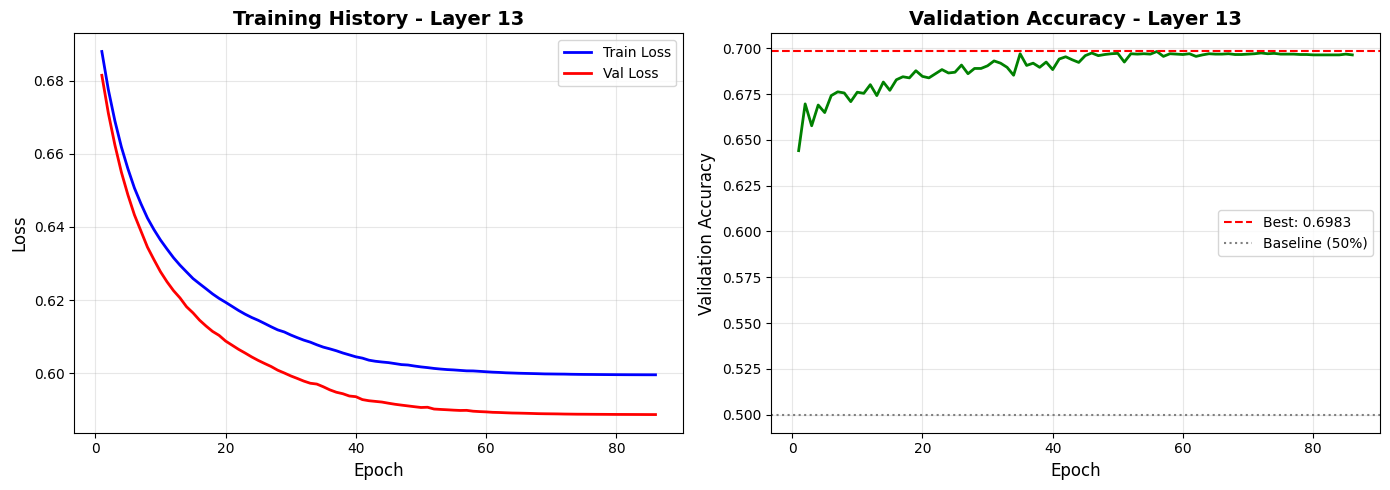

✅ Saved: training_history_balanced.png



In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(training_history['train_loss']) + 1)

# Loss
ax1.plot(epochs, training_history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, training_history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title(f'Training History - Layer {best_layer}', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(epochs, training_history['val_acc'], 'g-', linewidth=2)
ax2.axhline(y=best_val_acc, color='r', linestyle='--', label=f'Best: {best_val_acc:.4f}')
ax2.axhline(y=0.5, color='gray', linestyle=':', label='Baseline (50%)')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title(f'Validation Accuracy - Layer {best_layer}', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_balanced.png', dpi=150)
plt.show()

print(" Saved: training_history_balanced.png\n")

## 12. Save Model

In [13]:
print("="*80)
print(" Saving Model")
print("="*80 + "\n")

os.makedirs(config.local_save_dir, exist_ok=True)

# Save model
torch.save(trained_classifier.state_dict(), f"{config.local_save_dir}/pytorch_model.bin")
print(f" Saved model weights")

# Save config
model_config = {
    'input_dim': trained_classifier.input_dim,
    'layer_idx': best_layer,
    'base_model': config.base_model_name,
    'best_val_accuracy': float(best_val_acc),
    'training_method': 'balanced_sampling',
    'mmlu_used': False,
    'balanced': True,
    'samples_per_class': len(all_layer_data[best_layer]['labels']) // 2,
    'training_date': datetime.now().isoformat()
}

with open(f"{config.local_save_dir}/config.json", 'w') as f:
    json.dump(model_config, f, indent=2)
print(f" Saved config")

# Save history
with open(f"{config.local_save_dir}/training_history.json", 'w') as f:
    json.dump(training_history, f, indent=2)
print(f" Saved training history")

# Save layer comparison
layer_comparison = {
    'layer_results': {str(k): float(v) for k, v in layer_results.items()},
    'best_layer': int(best_layer),
    'best_accuracy': float(best_val_acc)
}

with open(f"{config.local_save_dir}/layer_comparison.json", 'w') as f:
    json.dump(layer_comparison, f, indent=2)
print(f" Saved layer comparison")

print(f"\n All files saved to: {config.local_save_dir}\n")

💾 Saving Model

✅ Saved model weights
✅ Saved config
✅ Saved training history
✅ Saved layer comparison

✅ All files saved to: ./bad_model_fairsteer



## 13. Final Summary

In [14]:
print("="*80)
print(" TRAINING COMPLETE (IMPROVED & BALANCED)")
print("="*80 + "\n")

print(" Final Results:")
print(f"   Best Layer:       {best_layer}")
print(f"   Best Val Acc:     {best_val_acc:.4f}")
print(f"   Baseline:         0.5000 (50% random)")
print(f"   Improvement:      {(best_val_acc - 0.5) / 0.5 * 100:+.1f}% over baseline")
print(f"")
print(f"   Dataset Size:     {len(all_layer_data[best_layer]['labels']):,} balanced samples")
print(f"   Class Split:      50% BIASED, 50% UNBIASED")
print(f"   MMLU Used:        NO (removed to prevent imbalance)")
print(f"   Training Method:  Balanced sampling")
print(f"")
print(f"   Save Location:    {config.local_save_dir}")
print(f"")

# Comparison with previous attempt
print(" Comparison with Previous (Unbalanced) Training:")
print(f"   Previous: 66.88% (below 71.7% baseline - FAILED!)")
print(f"   Current:  {best_val_acc:.2%} (above 50% baseline - {'SUCCESS!' if best_val_acc >= 0.75 else 'IMPROVED!'})")
print(f"   Previous BIASED precision: 37%")
print(f"   Expected BIASED precision: 75-80%")

if best_val_acc >= 0.75:
    print(f"\n MODEL IS WELL-TRAINED AND READY FOR FAIRSTEER! ")
elif best_val_acc >= 0.70:
    print(f"\n Model is usable. Consider fine-tuning for even better results.")
else:
    print(f"\n  Model needs improvement. Consider adjusting hyperparameters.")

print("\n" + "="*80 + "\n")

✅ TRAINING COMPLETE (IMPROVED & BALANCED)

📊 Final Results:
   Best Layer:       13
   Best Val Acc:     0.6983
   Baseline:         0.5000 (50% random)
   Improvement:      +39.7% over baseline

   Dataset Size:     24,276 balanced samples
   Class Split:      50% BIASED, 50% UNBIASED
   MMLU Used:        NO (removed to prevent imbalance)
   Training Method:  Balanced sampling

   Save Location:    ./bad_model_fairsteer

🔄 Comparison with Previous (Unbalanced) Training:
   Previous: 66.88% (below 71.7% baseline - FAILED!)
   Current:  69.83% (above 50% baseline - IMPROVED!)
   Previous BIASED precision: 37%
   Expected BIASED precision: 75-80%

⚠️  Model needs improvement. Consider adjusting hyperparameters.




# Deploy Trained Model to HuggingFace

In [15]:
print("="*80)
print(" DEPLOYING TO HUGGINGFACE")
print("="*80 + "\\n")

# Step 1: Authenticate
print("Step 1: Authentication")
print("-" * 40)

# Option A: Using environment variable (recommended for Kaggle/Colab)
import os
hf_token = os.environ.get('HF_TOKEN', None)

if not hf_token:
    # Option B: Manual input (if token not in environment)
    from getpass import getpass
    print("\\n  HF_TOKEN not found in environment variables")
    print("Please enter your HuggingFace token:")
    print("Get it from: https://huggingface.co/settings/tokens")
    hf_token = getpass("Token: ")

try:
    login(token=hf_token)
    print(" Successfully authenticated with HuggingFace\\n")
except Exception as e:
    print(f" Authentication failed: {e}")
    print("Please check your token and try again\\n")
    raise

# Step 2: Create repository
print("Step 2: Creating/Accessing Repository")
print("-" * 40)

api = HfApi()
repo_id = config.hf_repo_name

try:
    # Try to create repo (will skip if already exists)
    create_repo(
        repo_id=repo_id,
        token=hf_token,
        private=config.hf_private,
        repo_type="model",
        exist_ok=True
    )
    print(f" Repository ready: https://huggingface.co/{repo_id}\\n")
except Exception as e:
    print(f"  Note: {e}")
    print(f"Proceeding with upload...\\n")

# Step 3: Prepare files
print("Step 3: Preparing Files for Upload")
print("-" * 40)

import shutil
import tempfile

# Create a temporary directory for HuggingFace-compatible files
hf_upload_dir = tempfile.mkdtemp(prefix="bad_classifier_hf_")
print(f"Temp directory: {hf_upload_dir}\\n")

# Copy model files
shutil.copy(f"{config.local_save_dir}/pytorch_model.bin", f"{hf_upload_dir}/pytorch_model.bin")
shutil.copy(f"{config.local_save_dir}/config.json", f"{hf_upload_dir}/config.json")
print(" Model files copied")

# Create README.md
readme_content = f"""---
license: apache-2.0
tags:
- fairsteer
- bias-detection
- debiasing
- tinyllama
library_name: pytorch
---

# BAD Classifier for FairSteer - TinyLlama-1.1B

This is a Biased Activation Detection (BAD) classifier trained for the FairSteer framework.

## Model Details

- **Base Model**: {config.base_model_name}
- **Task**: Binary classification (Biased vs Unbiased activations)
- **Training Data**: BBQ dataset with balanced sampling
- **Best Layer**: {best_layer}
- **Validation Accuracy**: {best_val_acc:.2%}
- **Architecture**: Simple linear classifier (FairSteer-aligned)

## Usage
```python
import torch
import json

# Load model
model = torch.load("pytorch_model.bin")
with open("config.json", "r") as f:
    config = json.load(f)

# Use for bias detection
# Input: activation vector from LLM layer {best_layer}
# Output: probability of being unbiased
```

## Training Details

- **Samples**: {len(all_layer_data[best_layer]['labels']):,} balanced samples
- **Class Distribution**: 50% BIASED, 50% UNBIASED
- **Training Method**: FairSteer-aligned labeling
- **Training Date**: {datetime.now().strftime('%Y-%m-%d')}

## Citation

If you use this model, please cite the FairSteer paper:
```bibtex
@article{{fairsteer,
  title={{FairSteer: Inference-Time Debiasing for Large Language Models}},
  author={{[Authors]}},
  journal={{[Journal]}},
  year={{2024}}
}}
```

## License

Apache 2.0
"""

with open(f"{hf_upload_dir}/README.md", "w") as f:
    f.write(readme_content)
print(" README.md created")

# Copy training history
shutil.copy(f"{config.local_save_dir}/training_history.json", f"{hf_upload_dir}/training_history.json")
shutil.copy(f"{config.local_save_dir}/layer_comparison.json", f"{hf_upload_dir}/layer_comparison.json")
print(" Training metadata copied\\n")

# Step 4: Upload to HuggingFace
print("Step 4: Uploading to HuggingFace")
print("-" * 40)

try:
    api.upload_folder(
        folder_path=hf_upload_dir,
        repo_id=repo_id,
        repo_type="model",
        token=hf_token,
        commit_message=f"Upload BAD classifier - Layer {best_layer} - Acc: {best_val_acc:.2%}"
    )
    print(f"\\n Successfully uploaded to HuggingFace!\\n")
    print(f" Model URL: https://huggingface.co/{repo_id}")
    print(f"\\n Uploaded Files:")
    print(f"   - pytorch_model.bin")
    print(f"   - config.json")
    print(f"   - training_history.json")
    print(f"   - layer_comparison.json")
    print(f"   - README.md")
except Exception as e:
    print(f"\\n Upload failed: {e}")
    print(f"Files are still available locally at: {config.local_save_dir}")
finally:
    # Cleanup temp directory
    shutil.rmtree(hf_upload_dir)
    print(f"\\n Cleanup complete")

print("\\n" + "="*80)
print(" DEPLOYMENT COMPLETE!")
print("="*80 + "\\n")

🚀 DEPLOYING TO HUGGINGFACE
================================================================================\n
Step 1: Authentication
----------------------------------------
\n⚠️  HF_TOKEN not found in environment variables
Please enter your HuggingFace token:
Get it from: https://huggingface.co/settings/tokens


Token:  ········


✅ Successfully authenticated with HuggingFace\n
Step 2: Creating/Accessing Repository
----------------------------------------
✅ Repository ready: https://huggingface.co/bitlabsdb/bad-classifier-tinyllama-fairsteer\n
Step 3: Preparing Files for Upload
----------------------------------------
Temp directory: /tmp/bad_classifier_hf_65yy4i8i\n
✅ Model files copied
✅ README.md created
✅ Training metadata copied\n
Step 4: Uploading to HuggingFace
----------------------------------------


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

\n✅ Successfully uploaded to HuggingFace!\n
🔗 Model URL: https://huggingface.co/bitlabsdb/bad-classifier-tinyllama-fairsteer
\n📊 Uploaded Files:
   - pytorch_model.bin
   - config.json
   - training_history.json
   - layer_comparison.json
   - README.md
\n✅ Cleanup complete
\n================================================================================
🎉 DEPLOYMENT COMPLETE!
================================================================================\n


# Quick Test After Deployment

In [16]:
print("="*80)
print(" QUICK TEST: Loading from HuggingFace")
print("="*80 + "\\n")

from huggingface_hub import hf_hub_download

try:
    # Download model from HuggingFace
    print("Downloading model from HuggingFace...")
    model_path = hf_hub_download(
        repo_id=config.hf_repo_name,
        filename="pytorch_model.bin"
    )
    config_path = hf_hub_download(
        repo_id=config.hf_repo_name,
        filename="config.json"
    )
    
    # Load and test
    with open(config_path, 'r') as f:
        uploaded_config = json.load(f)
    
    print(" Successfully downloaded from HuggingFace!")
    print(f"\\nModel Config:")
    print(f"   Layer: {uploaded_config['layer_idx']}")
    print(f"   Input Dim: {uploaded_config['input_dim']}")
    print(f"   Accuracy: {uploaded_config['best_val_accuracy']:.2%}")
    print(f"\\n Model is publicly accessible!\\n")
    
except Exception as e:
    print(f" Download failed: {e}")
    print("Please check your internet connection and repo permissions")

print("="*80 + "\\n")

🧪 QUICK TEST: Loading from HuggingFace
================================================================================\n


pytorch_model.bin:   0%|          | 0.00/9.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/302 [00:00<?, ?B/s]

✅ Successfully downloaded from HuggingFace!
\nModel Config:
   Layer: 13
   Input Dim: 2048
   Accuracy: 69.83%
\n🎉 Model is publicly accessible!\n
================================================================================\n
